# Cleaning of Sberbank dataset

The purpose of this notebook is to fill in missing values and identify outliers.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
color = sns.color_palette()

%matplotlib inline

In [2]:
# import data
train = pd.read_csv("../input/train.csv").set_index('id')
test = pd.read_csv("../input/test.csv").set_index('id')
loc_fix = pd.read_excel(open("../input/BAD_ADDRESS_FIX.xlsx","rb"), sheetname='BAD').drop_duplicates('id').set_index('id')
print('Training data: ',train.shape)
print('Test data: ',test.shape)
print('Address fix: ',loc_fix.shape)

# import lat, lon data
latlon_train = pd.read_csv("../sberbankmoscowroads/train_lat_lon.csv").set_index('id')
latlon_test = pd.read_csv("../sberbankmoscowroads/test_lat_lon.csv").set_index('id')

# remove 'key' and 'tolerance_m' columns
latlon_train = latlon_train.drop('key',1)
latlon_test = latlon_test.drop('key',1)
latlon_train = latlon_train.drop('tolerance_m',1)
latlon_test = latlon_test.drop('tolerance_m',1)

Training data:  (30471, 291)
Test data:  (7662, 290)
Address fix:  (699, 279)


## Implement address fix and lat/lon

In [3]:
# first address fix
print('Number of bad entries in training set: ', len(set(train[train.kremlin_km == train.kremlin_km.min()].index)))
train.update(loc_fix)
test.update(loc_fix)
print('Fix in train: ', train.index.intersection(loc_fix.index).shape[0])
print('Fix in test : ', test.index.intersection(loc_fix.index).shape[0])

# drop entries that haven't been fixed
nument_before = train.shape[0]
bad_train_indexset = set(train[train.kremlin_km == train.kremlin_km.min()].index)
train.drop(bad_train_indexset, inplace=True)
nument_after = train.shape[0]
print('Dropped ', nument_before-nument_after, ' entries from training set.')

# add lat/lon
train['lat'] = np.NaN
train['lon'] = np.NaN
test['lat'] = np.NaN
test['lon'] = np.NaN
train.update(latlon_train)
test.update(latlon_test)

Number of bad entries in training set:  603
Fix in train:  550
Fix in test :  149
Dropped  53  entries from training set.


In [4]:
# view the dataframe
pd.set_option('display.max_columns', None)
train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

## Concatenate training and test sets for cleaning

In [5]:
test['price_doc'] = np.NaN
test['testdata'] = True
train['testdata'] = False

data_all = pd.concat([train,test])

# Missing values

Analysis inspired by: https://www.kaggle.com/agzamovr/a-very-extensive-exploratory-analysis-in-python and https://www.kaggle.com/nigelcarpenter/cleaning-the-data-using-latitude-and-longitude.

[<matplotlib.text.Text at 0x10b987710>, <matplotlib.text.Text at 0x1135245c0>]

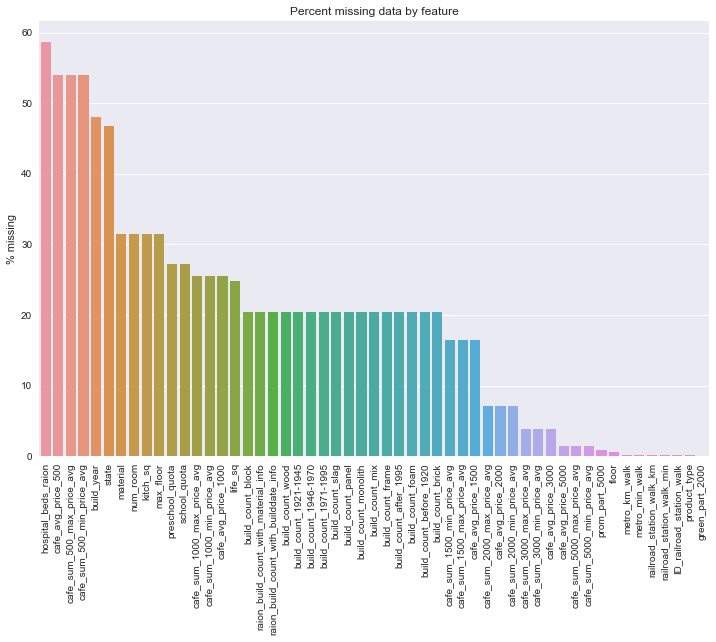

In [6]:
# fraction of missing values
data_na = (data_all.isnull().sum() / len(train)) * 100

# keep only columns with missing values
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
data_na = data_na.drop('price_doc')

# plot
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [7]:
# get features from timestamp
data_all['time_year'] = data_all['timestamp']
data_all['time_month'] = data_all['timestamp']
data_all['time_day'] = data_all['timestamp']
data_all['time_year'] = data_all['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
data_all['time_month'] = data_all['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
data_all['time_day'] = data_all['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

### Max Floor

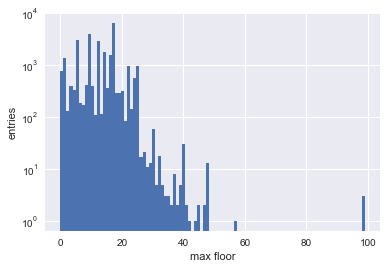

In [8]:
# look at max_floor
plt.figure()
plt.hist(data_all['max_floor'].dropna(),bins=100)
plt.yscale('log')
plt.xlabel('max floor')
plt.ylabel('entries')
plt.show()

In [9]:
# for max_floor > 47 and max_floor == 0, set to NaN
# (the tallest building in Moscow is 47 floors)
data_all.loc[data_all['max_floor'] > 47, 'max_floor'] = np.NaN
data_all.loc[data_all['max_floor'] == 0, 'max_floor'] = np.NaN

# for max_floor < floor, set to NaN
data_all.loc[data_all['max_floor'] < data_all['floor'], 'max_floor'] = np.NaN


### Build Year

In [10]:
# look at build_year
print(data_all.build_year.dropna().astype('int').sort_values().unique())

[       0        1        2        3       20       71      215     1691
     1860     1875     1876     1886     1890     1895     1896     1898
     1900     1902     1904     1905     1906     1907     1908     1910
     1911     1912     1914     1915     1917     1920     1924     1925
     1926     1927     1928     1929     1930     1931     1932     1933
     1934     1935     1936     1937     1938     1939     1940     1941
     1942     1943     1945     1946     1947     1948     1949     1950
     1951     1952     1953     1954     1955     1956     1957     1958
     1959     1960     1961     1962     1963     1964     1965     1966
     1967     1968     1969     1970     1971     1972     1973     1974
     1975     1976     1977     1978     1979     1980     1981     1982
     1983     1984     1985     1986     1987     1988     1989     1990
     1991     1992     1993     1994     1995     1996     1997     1998
     1999     2000     2001     2002     2003     2

A few comments about these numbers:
  * The single integers are typos.
  * 20, 71, 215 are typos.
  * 1691 is probably a typo -- should be 1961?
  * 4965 and 20052009 are typos

An analysis of these numbers was done at https://www.kaggle.com/nigelcarpenter/cleaning-the-data-using-latitude-and-longitude.
The strategy was to compare suspicious numbers with other sales at the same lat/lon coordinates.  The following are the resulting cleaning prescriptions:
  * 1691 should be 1961
  * 215 should be 2015
  * 4965 should be 1965
  * 2 should be 2014
  * 3 should be 2013 and 1960 (I will choose 2013 for now)
  * 20 should be 2014
  * 20052009 should be 2009
  * Set NaN for 0, 1, 71.

In [11]:
data_all.loc[data_all['build_year'] == 1691, 'build_year'] = 1961
data_all.loc[data_all['build_year'] == 215, 'build_year'] = 2015
data_all.loc[data_all['build_year'] == 4965, 'build_year'] = 1965
data_all.loc[data_all['build_year'] == 2, 'build_year'] = 2014
data_all.loc[data_all['build_year'] == 3, 'build_year'] = 2013 #1960
data_all.loc[data_all['build_year'] == 20, 'build_year'] = 2014
data_all.loc[data_all['build_year'] == 20052009, 'build_year'] = 2009
data_all.loc[data_all['build_year'] == 0, 'build_year'] = np.NaN
data_all.loc[data_all['build_year'] == 1, 'build_year'] = np.NaN
data_all.loc[data_all['build_year'] == 71, 'build_year'] = np.NaN

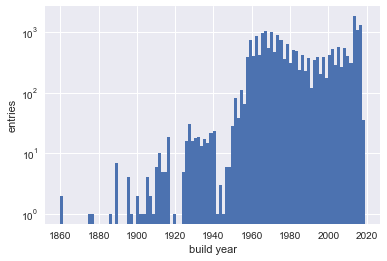

In [12]:
plt.figure()
plt.hist(data_all['build_year'].dropna(),bins=100)
plt.yscale('log')
plt.xlabel('build year')
plt.ylabel('entries')
plt.show()

### Full Sq

In [13]:
# look at full_sq
print(data_all.full_sq.dropna().astype('int').sort_values().unique())

[   0    1    2    5    6    9   10   11   12   13   14   15   16   17   18
   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33
   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48
   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78
   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93
   94   95   96   97   98   99  100  101  102  103  104  105  106  107  108
  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123
  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138
  139  140  141  142  143  144  145  146  147  148  149  150  151  153  154
  155  156  157  158  159  160  161  163  164  165  166  167  168  169  170
  172  173  174  176  177  178  179  181  182  183  184  185  186  187  189
  193  195  197  198  199  202  204  206  207  208  209  210  211  215  216
  218  219  

The anomalous cases are < 10 and > 200.  At https://www.kaggle.com/nigelcarpenter/cleaning-the-data-using-latitude-and-longitude, it is suggested to divide by 10 or 100 where appropriate, and set the rest to NaN.

In [14]:
data_all.loc[data_all['full_sq'] > 1000, 'full_sq'] = data_all['full_sq']/100
data_all.loc[data_all['full_sq'] > 250, 'full_sq'] = data_all['full_sq']/10

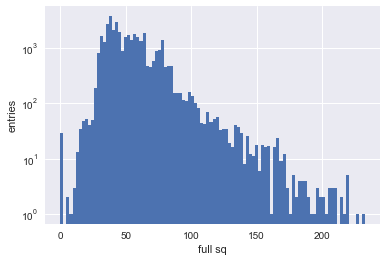

In [15]:
# look at full_sq
plt.figure()
plt.hist(data_all['full_sq'].dropna(),bins=100)
plt.yscale('log')
plt.xlabel('full sq')
plt.ylabel('entries')
plt.show()

In [16]:
# looks like there's a second subsample below 25 sq m,
# which seems like a reasonable lower-limit on apt sizes
data_all.loc[data_all['full_sq'] < 25, 'full_sq'] = np.NaN

In [17]:
# check life_sq
print(data_all.life_sq.dropna().astype('int').sort_values().unique())

[   0    1    2    7    8    9   10   11   12   13   14   15   16   17   18
   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33
   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48
   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78
   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93
   94   95   96   97   98   99  100  101  102  103  104  105  106  107  108
  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123
  124  125  126  128  129  130  133  134  135  136  138  139  140  141  142
  143  144  145  146  147  148  149  150  151  153  154  155  157  158  159
  160  162  163  165  166  172  174  176  178  179  183  189  191  195  197
  209  232  237  259  281  283  301  325  349  361  407  426  435  458  637
  742  802  869 7478]


In [18]:
# do the same with life_sq
data_all.loc[data_all['life_sq'] > 1000, 'life_sq'] = data_all['life_sq']/100
data_all.loc[data_all['life_sq'] > 250, 'life_sq'] = data_all['life_sq']/10
data_all.loc[data_all['life_sq'] < 10, 'life_sq'] = np.NaN

# if life_sq > full_sq, set to NaN
data_all.loc[data_all['life_sq'] > data_all['full_sq'], 'life_sq'] = np.NaN

### Other features
There are a number of features that are location-dependent.  We could get the missing values from neighboring properties using lat/lon coordinates.

For now, we will skip this step...

The most important feature is full_sq.  Let's try to fill in the missing values using the correlations between full_sq, life_sq, and kitchen_sq.  For the other missing values, we will take the simple mean for now.

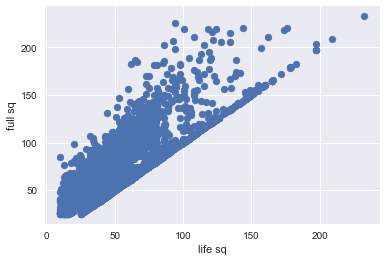

In [19]:
# life vs full sq
plt.figure()
plt.scatter(data_all['life_sq'],data_all['full_sq'])
plt.xlabel('life sq')
plt.ylabel('full sq')
plt.show()

The plot above looks like it has two subsamples -- one with full=life, and one with full>life.

How many properties with full=life?

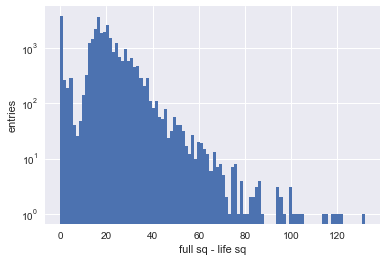

In [20]:
# look at full_sq-life_sq
diff = data_all['full_sq'] - data_all['life_sq']
plt.figure()
plt.hist(diff.dropna(),bins=100)
plt.yscale('log')
plt.xlabel('full sq - life sq')
plt.ylabel('entries')
plt.show()

Looks to me like a subsample below diff=10.  Let's set those to NaN.

In [21]:
# if full_sq - life_sq < 8, set to NaN
data_all.loc[data_all['life_sq'] > data_all['full_sq'] - 8, 'life_sq'] = np.NaN

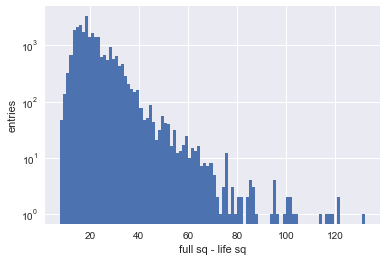

In [22]:
# look at full_sq-life_sq
diff = data_all['full_sq'] - data_all['life_sq']
plt.figure()
plt.hist(diff.dropna(),bins=100)
plt.yscale('log')
plt.xlabel('full sq - life sq')
plt.ylabel('entries')
plt.show()

Much better.  Now back to the scatter plot.

Fit params:  [ 1.40636125  9.26895028]
chi2/ndof =  [ 92.64383347]


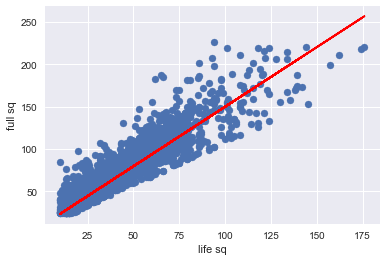

In [23]:
# life vs full sq

# fit a simple regression line
idx = np.isfinite(data_all['life_sq']) & np.isfinite(data_all['full_sq'])
fit, resid, _, _, _ = np.polyfit(data_all[idx].life_sq.values, data_all[idx].full_sq.values, deg=1, full=True)
print('Fit params: ', fit)
print('chi2/ndof = ', resid/(len(data_all[idx])/2))

# plot
plt.figure()
plt.scatter(data_all[idx].life_sq, data_all[idx].full_sq)
plt.plot(data_all[idx].life_sq, fit[1] + data_all[idx].life_sq*fit[0], color='red')
plt.xlabel('life sq')
plt.ylabel('full sq')
plt.show()


According to this line, we have: full_sq = 9.27 + 1.41*life_sq.

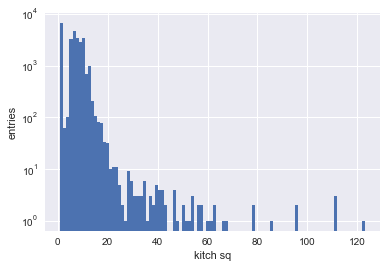

In [24]:
# look at kitch_sq
data_all.loc[data_all['kitch_sq'] > 500, 'kitch_sq'] = np.NaN
data_all.loc[data_all['kitch_sq'] == 0, 'kitch_sq'] = np.NaN
data_all.loc[data_all['kitch_sq']+data_all['life_sq'] >= data_all['full_sq'], 'kitch_sq'] = np.NaN

plt.figure()
plt.hist(data_all['kitch_sq'].dropna(),bins=100)
plt.yscale('log')
plt.xlabel('kitch sq')
plt.ylabel('entries')
plt.show()

Fit params:  [ 1.3281851   1.14997958]
chi2/ndof =  [ 54.11330846]


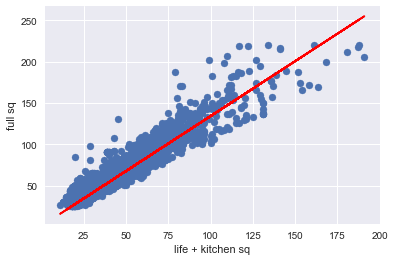

In [25]:
# plot

idx = np.isfinite(data_all['life_sq']) & np.isfinite(data_all['full_sq']) & np.isfinite(data_all['kitch_sq'])
fit2, resid2, _, _, _ = np.polyfit(data_all[idx].life_sq+data_all[idx].kitch_sq, data_all[idx].full_sq, deg=1, full=True)
print('Fit params: ', fit2)
print('chi2/ndof = ', resid2/(len(data_all[idx])/2))

plt.figure()
plt.scatter(data_all['life_sq']+data_all['kitch_sq'], data_all['full_sq'])
plt.plot(data_all[idx].life_sq+data_all[idx].kitch_sq, fit2[1] + (data_all[idx].life_sq+data_all[idx].kitch_sq)*fit2[0], color='red')
plt.xlabel('life + kitchen sq')
plt.ylabel('full sq')
plt.show()

This regression gives us: full_sq = 1.15 + 1.33*(life_sq+kitch_sq)

### Fill in missing sq values

In [26]:
print('Missing values (before): ')
print('full_sq = ', data_all['full_sq'].isnull().values.sum())
print('life_sq = ', data_all['life_sq'].isnull().values.sum())
print('kitch_sq = ', data_all['kitch_sq'].isnull().values.sum())

for i, row in data_all.iterrows():
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isfinite(row['kitch_sq']):
        data_all.set_value(i, 'full_sq', 1.15 + 1.33*(row['life_sq']+row['kitch_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['kitch_sq']):
        data_all.set_value(i, 'life_sq', (row['full_sq']-1.15)/1.33 - row['kitch_sq'] )
    if np.isnan(row['kitch_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['life_sq']):
        data_all.set_value(i, 'kitch_sq', (row['full_sq']-1.15)/1.33 - row['life_sq'] )
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isnan(row['kitch_sq']):
        data_all.set_value(i, 'full_sq', 9.27 + 1.41*(row['life_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isnan(row['kitch_sq']):
        data_all.set_value(i, 'life_sq', (row['full_sq']-9.27)/1.41 )

print('\nMissing values (after): ')
print('full_sq = ', data_all['full_sq'].isnull().values.sum())
print('life_sq = ', data_all['life_sq'].isnull().values.sum())
print('kitch_sq = ', data_all['kitch_sq'].isnull().values.sum())

Missing values (before): 
full_sq =  246
life_sq =  12857
kitch_sq =  11370

Missing values (after): 
full_sq =  45
life_sq =  45
kitch_sq =  5376


### Check extreme values of price_doc/full_sq

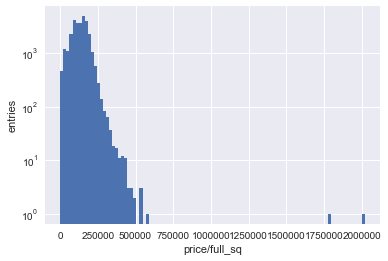

In [27]:
idx = np.isfinite(data_all['price_doc']) & np.isfinite(data_all['full_sq'])
plt.figure()
plt.hist(data_all[idx].price_doc/data_all[idx].full_sq,bins=100)
plt.xlabel('price/full_sq')
plt.ylabel('entries')
plt.yscale('log')
plt.show()

In [28]:
# drop extreme values
data_all = data_all[ (data_all['price_doc']/data_all['full_sq'] < 1e6) ]

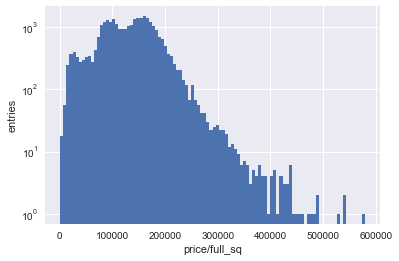

In [29]:
idx = np.isfinite(data_all['price_doc']) & np.isfinite(data_all['full_sq'])
plt.figure()
plt.hist(data_all[idx].price_doc/data_all[idx].full_sq,bins=100)
plt.xlabel('price/full_sq')
plt.ylabel('entries')
plt.yscale('log')
plt.show()

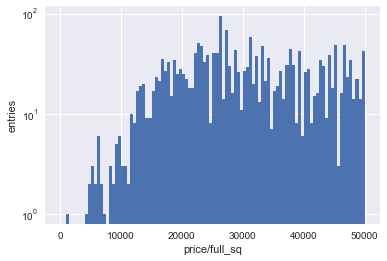

In [30]:
# zoom in to low region
plt.figure()
plt.hist(data_all[idx].price_doc/data_all[idx].full_sq, bins=100, range=[0,5e4])
plt.xlabel('price/full_sq')
plt.ylabel('entries')
plt.yscale('log')
plt.show()

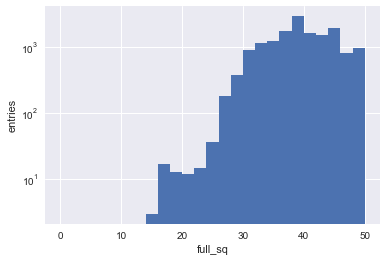

In [31]:
# check full_sq again
plt.figure()
plt.hist(data_all.full_sq.dropna(), bins=25, range=[0,50])
plt.xlabel('full_sq')
plt.ylabel('entries')
plt.yscale('log')
plt.show()

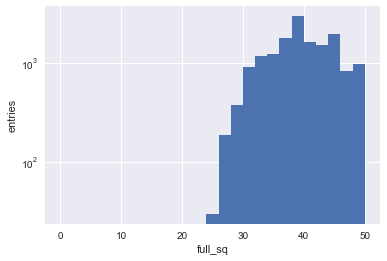

In [32]:
# remove full_sq < 25 (already did this, but some artifacts from regression)
data_all = data_all[ (data_all['full_sq'] >= 25) | (data_all['full_sq'] == np.NaN) | (data_all['testdata'] == True) ]

plt.figure()
plt.hist(data_all.full_sq.dropna(), bins=25, range=[0,50])
plt.xlabel('full_sq')
plt.ylabel('entries')
plt.yscale('log')
plt.show()

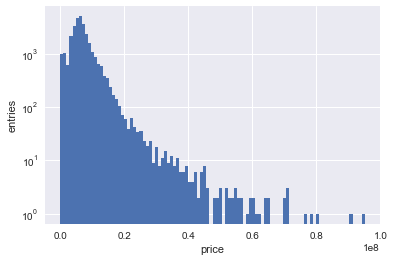

In [33]:
plt.figure()
plt.hist(data_all['price_doc'].dropna(),bins=100)
plt.yscale('log')
plt.xlabel('price')
plt.ylabel('entries')
plt.show()

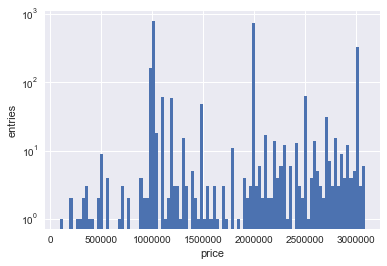

In [34]:
plt.figure()
plt.hist(data_all[ (data_all['product_type'] == 'Investment') & (data_all['price_doc'] < 3.1e6) ].price_doc.dropna(),bins=100)
plt.yscale('log')
plt.xlabel('price')
plt.ylabel('entries')
plt.show()